In [1]:
!git clone https://github.com/Etienne-bdt/BEI-SIA25
!unzip /content/BEI-SIA25/data.zip -d /content/BEI-SIA25/

Cloning into 'BEI-SIA25'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 244 (delta 63), reused 48 (delta 48), pack-reused 148 (from 3)
Receiving objects: 100% (244/244), 110.25 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Archive:  /content/BEI-SIA25/data.zip
   creating: /content/BEI-SIA25/data/
   creating: /content/BEI-SIA25/data/31000/
   creating: /content/BEI-SIA25/data/31000/patches/
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_

In [2]:
import sys
sys.path.append("/content/BEI-SIA25")

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.dataloader import CadastreSen2Dataset
from utils.index_calculation import BSI, NDBI, NDMI, NDVI, NDWI

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data

Get the data

Prepare pytorch dataset

In [5]:
dataset = CadastreSen2Dataset(image_path="/content/BEI-SIA25/data/")

Prepare dataloader

In [40]:
batch_size = 16
num_threads = 0

#Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Model definition

In [72]:
class Conv2DRegressionModel(nn.Module):
    def __init__(self, int_channels: int = 11):
        super(Conv2DRegressionModel, self).__init__()
        self.nb_channel = int_channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(int_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(2),
            nn.Tanh()
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        y = self.enc1(X)
        enc1_out = y
        y = self.enc2(y)
        enc2_out = y
        y = self.enc3(y)
        enc3_out = y
        y = self.enc4(y)
        y = self.dec4(y)
        y = torch.cat((y, enc3_out), dim=1)
        y = self.dec3(y)
        y = torch.cat((y, enc2_out), dim=1)
        y = self.dec2(y)
        y = torch.cat((y, enc1_out), dim=1)
        y = self.dec1(y)

        return y

class DiffusionModel(nn.Module):
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alpha_cumprod[:-1]]).to(device)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod).to(device)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod).to(device)
        self.posterior_variance = self.beta * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)

        self.model = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, mask, t):
        noise = torch.randn_like(x).to(device)
        x_t = self.sqrt_alpha_cumprod[t] * x + self.sqrt_one_minus_alpha_cumprod[t] * noise
        return self.model(torch.cat((x_t * (1 - mask), mask), dim=1))

    def p_losses(self, x_start, mask, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.sqrt_alpha_cumprod[t] * x_start + self.sqrt_one_minus_alpha_cumprod[t] * noise
        predicted_noise = self.forward(x_noisy, mask, t)
        return nn.MSELoss()(predicted_noise, noise)

    def sample(self, x, mask):
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.tensor([t]).to(device)
            predicted_noise = self.forward(x, mask, t_tensor)
            if t > 0:
                noise = torch.randn_like(x)
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t]) + torch.sqrt(self.posterior_variance[t]) * noise
            else:
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t])
        return x

# Train the model

In [42]:
from skimage.metrics import structural_similarity as ssim


In [74]:
n_epochs = 50
learning_rate = 0.001

model = Conv2DRegressionModel()
model = model.to(device)


#metric = im.SSIM(data_range=1.0)
# metric.attach(im.default_evaluator, 'ssim')
# preds = torch.rand([4, 3, 16, 16])
# target = preds * 0.75
# state = im.default_evaluator.run([[preds, target]])
# print(state.metrics['ssim'])

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(val_loader)

train_loss_comp, val_loss_comp = [], []
train_loss_pred, val_loss_pred = [], []
train_loss_comp_pred, val_loss_comp_pred = [], []
train_loss_tot, val_loss_tot = [], []
train_loss_visu, val_loss_visu = [], []
ssim_vals = []
best_loss=1000000
for epoch in tqdm(range(n_epochs)):
    model.train()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0
    ssim_v = 0

    for x, y, mask in train_loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        x,y,mask = x.float(), y.float(), mask.float()
        optimizer.zero_grad()
        # img_2018, img_2024 = img_2018.to(device), img_2024.to(device)
        # Forward pass
        x=torch.cat([x,mask],axis=1)
        y_pred = model(x) # image 2024 prédite à partir de 2018

        # Ind_comp = NDVI(y_pred)
        # Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
        # Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
        # Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
        # Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)

        Ind_real = y[:,5:7,:,:]
        # print("ind real shape",Ind_real.shape)
        # Ind_pred = y_pred[:,5:,:,:]
        Ind_pred = y_pred
        # weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster
        # weights = torch.tensor([0.5, 0.5], device=device)

        # visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:]) # loss globale
        # loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real)) # comparaison des indices calculés
        loss_pred = loss_fn(y[:,5:7,:,:], y_pred)
        # loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred)) # comparaison des indices calculés et prédits

        # total_loss = visual_loss + loss_comp + loss_pred + loss_comp_pred
        total_loss=loss_pred
        # accu_visual += visual_loss.item()
        # accu_comp += loss_comp.item()
        accu_pred += loss_pred.item()
        # accu_comp_pred += loss_comp_pred.item()
        accu_total += total_loss.item()
        # Backward pass
        total_loss.backward()
        optimizer.step()

    # train_loss_visu.append(accu_visual/val_set_len)
    # train_loss_comp.append(accu_comp / train_set_len)
    train_loss_pred.append(accu_pred / train_set_len)
    # train_loss_comp_pred.append(accu_comp_pred / train_set_len)
    train_loss_tot.append(accu_total / train_set_len)
    # Validation - no gradient & eval mode
    model.eval()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0
    ssim_v = 0
    with torch.no_grad():
        for x, y, mask in val_loader:
            x,y,mask = x.to(device), y.to(device), mask.to(device)
            x,y,mask = x.float(), y.float(), mask.float()

            x=torch.cat([x,mask],axis=1)
            y_pred = model(x)
            # Ind_comp = NDVI(y_pred)
            # Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
            # Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
            # Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
            # Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
            Ind_real = y[:,5:7,:,:]
            # print("ind real shape",Ind_real.shape)
            # Ind_pred = y_pred[:,5:,:,:]
            Ind_pred = y_pred
            # print("ind pred shape",Ind_pred.shape)
            # visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:])
            # loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real))
            loss_pred = loss_fn(y[:,5:7,:,:], y_pred)
            # loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred))
            # total_loss = visual_loss + loss_comp + loss_pred + loss_comp_pred
            total_loss=loss_pred
            # accu_visual += visual_loss.item()
            # accu_comp += loss_comp.item()
            accu_pred += loss_pred.item()
            # accu_comp_pred += loss_comp_pred.item()
            accu_total += total_loss.item()
            for i in range(y.shape[0]):
              ssim_v += ssim(y[i,5,:,:].cpu().detach().numpy(),y_pred[i,0,:,:].cpu().detach().numpy(), data_range=2)
              ssim_v += ssim(y[i,6,:,:].cpu().detach().numpy(),y_pred[i,1,:,:].cpu().detach().numpy(), data_range=2)

    # val_loss_visu.append(accu_visual/val_set_len)
    # val_loss_comp.append(accu_comp / val_set_len)
    val_loss_pred.append(accu_pred / val_set_len)
    # val_loss_comp_pred.append(accu_comp_pred / val_set_len)
    val_loss_tot.append(accu_total / val_set_len)
    ssim_vals.append(ssim_v/ (2*val_set_len))

    if accu_total < best_loss:
        best_loss = accu_total
        torch.save(model.state_dict(), "best_model.pt")

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss_tot[-1]:.4f} - Val loss: {val_loss_tot[-1]:.4f} - SSIM val: {ssim_vals[-1]:.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pt")


  2%|▏         | 1/50 [00:00<00:17,  2.82it/s]

Epoch 1/50 - Train loss: 0.2236 - Val loss: 0.1333 - SSIM val: 0.7038


  4%|▍         | 2/50 [00:00<00:14,  3.26it/s]

Epoch 2/50 - Train loss: 0.1337 - Val loss: 0.2369 - SSIM val: 1.0428


  6%|▌         | 3/50 [00:00<00:13,  3.40it/s]

Epoch 3/50 - Train loss: 0.1224 - Val loss: 0.1329 - SSIM val: 1.1946


  8%|▊         | 4/50 [00:01<00:13,  3.54it/s]

Epoch 4/50 - Train loss: 0.1110 - Val loss: 0.1336 - SSIM val: 1.2463


 10%|█         | 5/50 [00:01<00:12,  3.59it/s]

Epoch 5/50 - Train loss: 0.1002 - Val loss: 0.0934 - SSIM val: 1.3511


 12%|█▏        | 6/50 [00:01<00:12,  3.62it/s]

Epoch 6/50 - Train loss: 0.0945 - Val loss: 0.1242 - SSIM val: 1.4561


 14%|█▍        | 7/50 [00:01<00:11,  3.59it/s]

Epoch 7/50 - Train loss: 0.0878 - Val loss: 0.0744 - SSIM val: 1.5773


 16%|█▌        | 8/50 [00:02<00:11,  3.62it/s]

Epoch 8/50 - Train loss: 0.0855 - Val loss: 0.0780 - SSIM val: 1.5818


 18%|█▊        | 9/50 [00:02<00:11,  3.64it/s]

Epoch 9/50 - Train loss: 0.0762 - Val loss: 0.0568 - SSIM val: 1.6823


 20%|██        | 10/50 [00:02<00:11,  3.63it/s]

Epoch 10/50 - Train loss: 0.0728 - Val loss: 0.0627 - SSIM val: 1.7007


 22%|██▏       | 11/50 [00:03<00:10,  3.65it/s]

Epoch 11/50 - Train loss: 0.0677 - Val loss: 0.0925 - SSIM val: 1.5261


 24%|██▍       | 12/50 [00:03<00:10,  3.64it/s]

Epoch 12/50 - Train loss: 0.0633 - Val loss: 0.0562 - SSIM val: 1.7798


 26%|██▌       | 13/50 [00:03<00:10,  3.69it/s]

Epoch 13/50 - Train loss: 0.0588 - Val loss: 0.0972 - SSIM val: 1.6419


 28%|██▊       | 14/50 [00:03<00:09,  3.65it/s]

Epoch 14/50 - Train loss: 0.0550 - Val loss: 0.0529 - SSIM val: 1.8114


 30%|███       | 15/50 [00:04<00:09,  3.69it/s]

Epoch 15/50 - Train loss: 0.0592 - Val loss: 0.0891 - SSIM val: 1.7676


 32%|███▏      | 16/50 [00:04<00:09,  3.70it/s]

Epoch 16/50 - Train loss: 0.0550 - Val loss: 0.0603 - SSIM val: 1.8094


 34%|███▍      | 17/50 [00:04<00:08,  3.69it/s]

Epoch 17/50 - Train loss: 0.0517 - Val loss: 0.1340 - SSIM val: 1.5525


 36%|███▌      | 18/50 [00:04<00:08,  3.73it/s]

Epoch 18/50 - Train loss: 0.0532 - Val loss: 0.0772 - SSIM val: 1.7575


 38%|███▊      | 19/50 [00:05<00:08,  3.67it/s]

Epoch 19/50 - Train loss: 0.0507 - Val loss: 0.0435 - SSIM val: 1.9049


 40%|████      | 20/50 [00:05<00:08,  3.70it/s]

Epoch 20/50 - Train loss: 0.0492 - Val loss: 0.0573 - SSIM val: 1.8406


 42%|████▏     | 21/50 [00:05<00:07,  3.66it/s]

Epoch 21/50 - Train loss: 0.0497 - Val loss: 0.1648 - SSIM val: 1.5857


 44%|████▍     | 22/50 [00:06<00:07,  3.60it/s]

Epoch 22/50 - Train loss: 0.0554 - Val loss: 0.0519 - SSIM val: 1.9148


 46%|████▌     | 23/50 [00:06<00:07,  3.59it/s]

Epoch 23/50 - Train loss: 0.0465 - Val loss: 0.0880 - SSIM val: 1.7684


 48%|████▊     | 24/50 [00:06<00:07,  3.62it/s]

Epoch 24/50 - Train loss: 0.0436 - Val loss: 0.0336 - SSIM val: 1.9491


 50%|█████     | 25/50 [00:06<00:06,  3.60it/s]

Epoch 25/50 - Train loss: 0.0463 - Val loss: 0.0907 - SSIM val: 1.8092


 52%|█████▏    | 26/50 [00:07<00:07,  3.06it/s]

Epoch 26/50 - Train loss: 0.0470 - Val loss: 0.0467 - SSIM val: 1.9751


 54%|█████▍    | 27/50 [00:07<00:07,  3.23it/s]

Epoch 27/50 - Train loss: 0.0516 - Val loss: 0.0650 - SSIM val: 1.8198


 56%|█████▌    | 28/50 [00:07<00:06,  3.33it/s]

Epoch 28/50 - Train loss: 0.0486 - Val loss: 0.0377 - SSIM val: 1.9812


 58%|█████▊    | 29/50 [00:08<00:06,  3.44it/s]

Epoch 29/50 - Train loss: 0.0432 - Val loss: 0.0394 - SSIM val: 2.0064


 60%|██████    | 30/50 [00:08<00:05,  3.51it/s]

Epoch 30/50 - Train loss: 0.0397 - Val loss: 0.0406 - SSIM val: 1.9848


 62%|██████▏   | 31/50 [00:08<00:05,  3.56it/s]

Epoch 31/50 - Train loss: 0.0417 - Val loss: 0.0435 - SSIM val: 1.9434


 64%|██████▍   | 32/50 [00:08<00:05,  3.60it/s]

Epoch 32/50 - Train loss: 0.0394 - Val loss: 0.0440 - SSIM val: 2.0068


 66%|██████▌   | 33/50 [00:09<00:04,  3.49it/s]

Epoch 33/50 - Train loss: 0.0393 - Val loss: 0.0382 - SSIM val: 2.0211


 68%|██████▊   | 34/50 [00:09<00:04,  3.30it/s]

Epoch 34/50 - Train loss: 0.0410 - Val loss: 0.0535 - SSIM val: 1.9961


 70%|███████   | 35/50 [00:09<00:04,  3.21it/s]

Epoch 35/50 - Train loss: 0.0403 - Val loss: 0.0572 - SSIM val: 1.9614


 72%|███████▏  | 36/50 [00:10<00:04,  3.17it/s]

Epoch 36/50 - Train loss: 0.0406 - Val loss: 0.1424 - SSIM val: 1.6965


 74%|███████▍  | 37/50 [00:10<00:04,  3.12it/s]

Epoch 37/50 - Train loss: 0.0420 - Val loss: 0.0839 - SSIM val: 1.7619


 76%|███████▌  | 38/50 [00:11<00:04,  2.99it/s]

Epoch 38/50 - Train loss: 0.0465 - Val loss: 0.0400 - SSIM val: 2.0235


 78%|███████▊  | 39/50 [00:11<00:03,  2.92it/s]

Epoch 39/50 - Train loss: 0.0404 - Val loss: 0.0550 - SSIM val: 1.8033


 80%|████████  | 40/50 [00:11<00:03,  2.81it/s]

Epoch 40/50 - Train loss: 0.0381 - Val loss: 0.0317 - SSIM val: 2.0297


 82%|████████▏ | 41/50 [00:12<00:03,  2.96it/s]

Epoch 41/50 - Train loss: 0.0343 - Val loss: 0.0362 - SSIM val: 2.0202


 84%|████████▍ | 42/50 [00:12<00:02,  3.12it/s]

Epoch 42/50 - Train loss: 0.0365 - Val loss: 0.0370 - SSIM val: 2.0436


 86%|████████▌ | 43/50 [00:12<00:02,  3.29it/s]

Epoch 43/50 - Train loss: 0.0360 - Val loss: 0.0562 - SSIM val: 2.0140


 88%|████████▊ | 44/50 [00:12<00:01,  3.42it/s]

Epoch 44/50 - Train loss: 0.0370 - Val loss: 0.0377 - SSIM val: 2.0285


 90%|█████████ | 45/50 [00:13<00:01,  3.49it/s]

Epoch 45/50 - Train loss: 0.0352 - Val loss: 0.0476 - SSIM val: 1.9989


 92%|█████████▏| 46/50 [00:13<00:01,  3.56it/s]

Epoch 46/50 - Train loss: 0.0369 - Val loss: 0.0438 - SSIM val: 2.0540


 94%|█████████▍| 47/50 [00:13<00:00,  3.62it/s]

Epoch 47/50 - Train loss: 0.0365 - Val loss: 0.0382 - SSIM val: 2.0539


 96%|█████████▌| 48/50 [00:13<00:00,  3.67it/s]

Epoch 48/50 - Train loss: 0.0348 - Val loss: 0.0334 - SSIM val: 2.0607


 98%|█████████▊| 49/50 [00:14<00:00,  3.66it/s]

Epoch 49/50 - Train loss: 0.0351 - Val loss: 0.0439 - SSIM val: 2.0430


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]

Epoch 50/50 - Train loss: 0.0364 - Val loss: 0.0355 - SSIM val: 2.0205


In [65]:
x,y,m = next(iter(val_loader))


tensor(-1.0000, dtype=torch.float64)
tensor(0.3117, dtype=torch.float64)


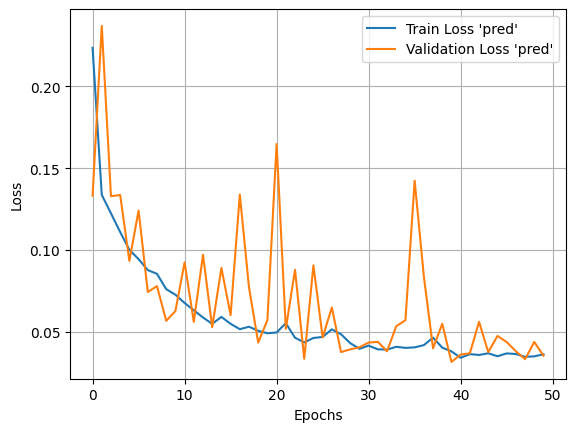

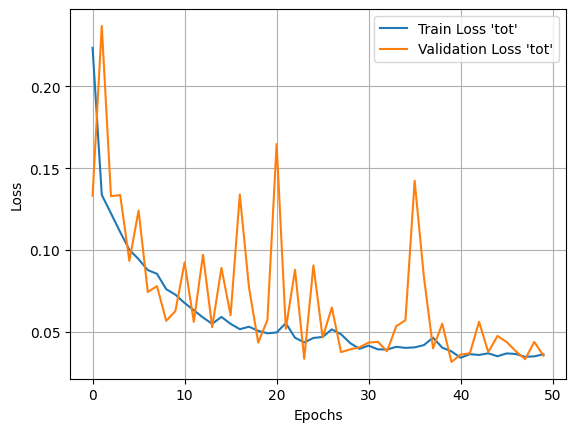

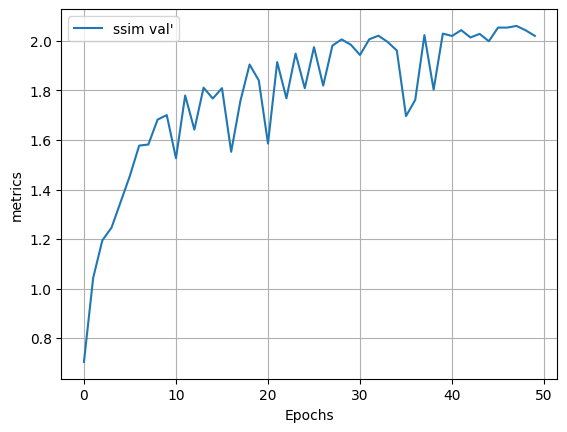

In [76]:
# plt.plot(train_loss_visu, label="Train Loss 'visu'")
# plt.plot(val_loss_visu, label="Validation Loss 'visu'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()


# plt.plot(train_loss_comp, label="Train Loss 'comp'")
# plt.plot(val_loss_comp, label="Validation Loss 'comp'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(train_loss_pred, label="Train Loss 'pred'")
# plt.plot(val_loss_pred, label="Validation Loss 'pred'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(train_loss_comp_pred, label="Train Loss 'comp_pred'")
# plt.plot(val_loss_comp_pred, label="Validation Loss 'comp_pred'")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()

plt.plot(train_loss_tot, label="Train Loss 'tot'")
plt.plot(val_loss_tot, label="Validation Loss 'tot'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(ssim_vals, label="ssim val'")
# plt.plot(val_loss_visu, label="Validation Loss 'visu'")
plt.xlabel("Epochs")
plt.ylabel("metrics")
plt.legend()
plt.grid()

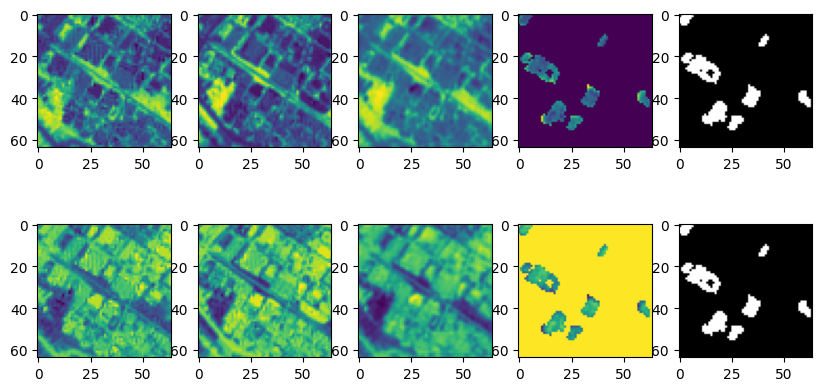

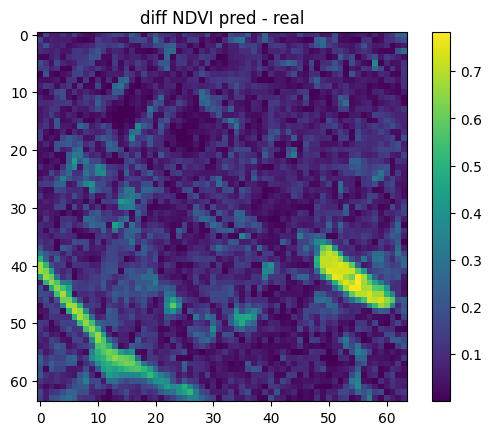

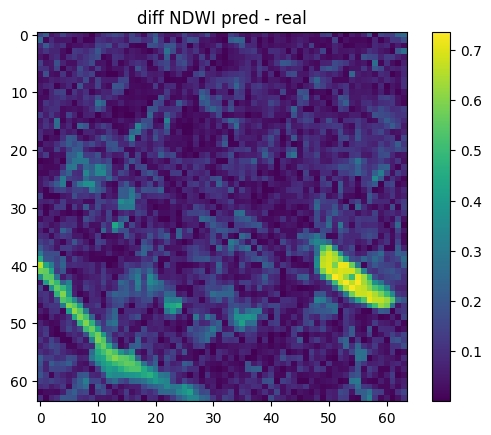

mean diff NDVI pred - real 0.119694114
mean diff NDWI pred - real 0.10808331


In [88]:
model.cpu()

x,y,mask = next(iter(val_loader))
x,y,mask = x.float(), y.float(), mask.float()
# x,y,mask = x[0:1,:,:,:], y[0:1,:,:,:], mask[0:1,:,:,:]
# x,y,mask = x.cpu(), y.tocpu(), mask.to(device)
x=torch.cat([x,mask],axis=1)
y_pred = model(x)
batch_img=0
fig, ax = plt.subplots(2, 5, figsize=(10,5))
# ax[0, 0].imshow((x[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
# ax[0, 1].imshow(y[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
# ax[0, 2].imshow(y_pred[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())

# ax[1, 0].imshow(x[batch_img, 5, :, :].detach().numpy())
# ax[1, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
# ax[1, 2].imshow(y_pred[batch_img, 5, :, :].detach().numpy())
ax[0, 0].imshow((x[batch_img, 5, :, :]).detach().numpy())
ax[0, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[0, 2].imshow(y_pred[batch_img, 0, :, :].detach().numpy())
ax[0, 3].imshow((y_pred[batch_img, 0, :, :]*mask[batch_img,0,:,:]).detach().numpy())
ax[0,4].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
ax[1, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
ax[1, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
ax[1, 2].imshow(y_pred[batch_img, 1, :, :].detach().numpy())
ax[1, 3].imshow((y_pred[batch_img, 1, :, :]*mask[batch_img,0,:,:]).detach().numpy())
ax[1,4].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
# ax[2, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
# ax[2, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
# # ax[2, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
# ax[3, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
# ax[3, 1].imshow(y[batch_img, 7, :, :].detach().numpy())
# # ax[3, 2].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
# ax[4, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
# ax[4, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
# # ax[4, 2].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
# ax[5, 0].imshow(x[batch_img, 9, :, :].detach().numpy())
# ax[5, 1].imshow(y[batch_img, 9, :, :].detach().numpy())
# # ax[5, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()





plt.figure()
plt.imshow(np.abs((y_pred[batch_img, 0, :, :]-y[batch_img, 5, :, :]).detach().numpy()))
plt.colorbar()
plt.title("diff NDVI pred - real")
plt.show()

plt.figure()
plt.imshow(np.abs((y_pred[batch_img, 1, :, :]-y[batch_img, 6, :, :]).detach().numpy()))
plt.colorbar()
plt.title("diff NDWI pred - real")
plt.show()

print("mean diff NDVI pred - real",np.mean(np.abs(((y_pred[batch_img, 0, :, :]-y[batch_img, 5, :, :]).detach().numpy()))))
print("mean diff NDWI pred - real",np.mean(np.abs((y_pred[batch_img, 1, :, :]-y[batch_img, 6, :, :]).detach().numpy())))